# LT2222 V23 Assignment 2: Slot Detection

In this assignment you'll be working with the same data as in Assignment 1 (but with a different focus). This data is made available for the *Slot and Intent Detection for Low Resource
language varieties (SID4LR)* shared task. 

Given an utterance, the shared task consists on identifying the intent of the speaker along with the key spans that require an action from the system. For example, given the utterance *Add reminder to swim at 11am tomorrow*, the intent is *add reminder*, while the slots are *to do* and *datetime*. **In this assignment, we'll focus on the slot detection only.** 

The dataset consists of 13 languages (en, de-st, de, da, nl, it, sr, id, ar, zh, kk, tr, ja).

For more details about the data please check [this paper](https://aclanthology.org/2021.naacl-main.197.pdf) by van der Goot et al., (2021).

## General instructions

You'll do all the work inside this notebook and submit your edited notebook back into Canvas. You many not copy code from elsewhere, but you can use functions from any module currently available on mltgpu, where the notebook will be tested. A major goal of the assignment is, in fact, for you to find them yourself and apply them. Only edit the notebook in the places where we specify you should do so.

You will need to give reasonable, but not excessively verbose, documentation of your code so that we understand what you did.

**The assignment is officially due at 23:59 CET on Wednesday March 8, 2023. There are 33 points and 5 bonus points.**

### 1. Choose a language and download the corresponding train, validation and test data splits.  (2 points)

It doesn't matter if it's the same language as in Assignment 1 or a different one.

https://bitbucket.org/robvanderg/sid4lr/src/master/xSID-0.4/

Store the chosen data into a directory `data/`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Import all necessary modules here. (1 point)

In [1]:
# An additional module
!pip install conllu
from IPython.display import clear_output
clear_output()
import conllu

In [2]:
import numpy as np
import pandas as pd
from nltk import everygrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

### 3. Import the data into Python. (6 points)

Write code to read the data into Python. Here we're focusing on the slot detection task. This means that you need extract the utterances along with their IOB tags. If you're not familiar with the IOB format, check out this Wikipedia entry: [IOB format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

In [3]:
def get_dataframe_from_Conll(path, filename, canRemoveDuplicates=True): 
    dataset_path = os.path.join(path, filename)
    data = open(dataset_path, mode='r', encoding='utf-8')
    data = data.read()
    sentences = conllu.parse(data, fields=["id", "form", "intent", "tag"])
    xT = list()
    yT = list()
    tagT = list()
    for iSentence in sentences:
        sentenceString = list()
        intentString = list()
        tagString = list()
        for iToken in list(iSentence):
            sentenceString.append(iToken['form'].lower())
            intentString.append(iToken['intent'].lower())
            tagString.append(iToken['tag'].lower())
        xT.append(' '.join(sentenceString))
        yT.append(list(set(intentString))[0])
        tagT.append(list(tagString))

    data = {'X': xT, 'y': tagT, 'intent': yT}
    df = pd.DataFrame(data=data)
    if (canRemoveDuplicates == True):
        df.drop_duplicates(subset=['X'], inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df

In [4]:
# As instructed the data is in data folder and I assume that CWD is one directory before data dir.
# dataset = os.path.join(os.getcwd(), 'data')
dataset =  "/content/drive/My Drive/MLSNLP/Data/"
df_train = get_dataframe_from_Conll(dataset, 'en.train.conll', canRemoveDuplicates=True)
df_valid = get_dataframe_from_Conll(dataset, 'en.valid.conll', canRemoveDuplicates=True)

In [5]:
df_train.head(5)

,X,y,intent
0,tell me the weather report for half moon bay,"[o, o, o, o, o, o, b-location, i-location, i-l...",weather/find
1,give me the latest forecast for half moon bay,"[o, o, o, b-datetime, o, o, b-location, i-loca...",weather/find
2,give me friday's forecast for half moon bay,"[o, o, b-datetime, o, o, b-location, i-locatio...",weather/find
3,i need to know the latest forecast for half mo...,"[o, o, o, o, o, b-datetime, o, o, b-datetime, ...",weather/find
4,do you have thursday's weather report for half...,"[o, o, o, b-datetime, o, o, o, b-location, i-l...",weather/find


### 4. Think about the features. (1 points)

In this task, we have a one token to one label prediction problem. (You may recall that in assignment 1, we had a one utterance to one label problem). One modeling option here would be to do a bag-of-words for predicting each label individually. 

    1. Why is that not the best for our task?

**Enter your answer below.**

In [6]:
repr('The bag of ')

"'The bag of '"

### 5. Build your features. (12 points)

When we predict sequences, we usually use a family of algorithms specialized on sequences, for example, HMMs (which you may recall from language modeling) or CRFs. We are **not** covering these in LT2222. However, we can still approximate a sequence, i.e., use the context, in the form of individual features. For this, we'll represent each training example as:

*previous token, current token, next token, current label*

Extract the training examples so you have your **X and Y variables**. Then, transform them into sparce vectors relying on [Scikit-learn feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-extraction).  


**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

In [7]:
def add_words_beginning_end(df):
    df['X'] = df['X'].apply(lambda x: "{}{}".format('NonLabelToken ', x))
    df['X'] = df['X'].apply(lambda x: "{}{}".format(x, ' NonLabelToken'))
    return df

In [8]:
df_train = add_words_beginning_end(df_train)
df_valid = add_words_beginning_end(df_valid)

In [9]:
def append_n_grams_in_df(df, n=3):
    df['trigrams'] = df['X'].apply(lambda utterance: list(everygrams(utterance.split(), n, n)))
    return df

In [10]:
df_train = append_n_grams_in_df(df_train)
df_valid = append_n_grams_in_df(df_valid)

In [11]:
def get_trigrams_label(df):
    df['trigrams_label'] = df.apply(lambda a: dict(zip(a['trigrams'], a['y'])), axis=1)
    return df

df_train = get_trigrams_label(df_train)
df_valid = get_trigrams_label(df_valid)

In [12]:
df_train['trigrams_label'].head(10)

0    {('NonLabelToken', 'tell', 'me'): 'o', ('tell'...
1    {('NonLabelToken', 'give', 'me'): 'o', ('give'...
2    {('NonLabelToken', 'give', 'me'): 'o', ('give'...
3    {('NonLabelToken', 'i', 'need'): 'o', ('i', 'n...
4    {('NonLabelToken', 'do', 'you'): 'o', ('do', '...
5    {('NonLabelToken', 'do', 'you'): 'o', ('do', '...
6    {('NonLabelToken', 'give', 'me'): 'o', ('give'...
7    {('NonLabelToken', 'give', 'me'): 'o', ('give'...
8    {('NonLabelToken', 'give', 'me'): 'o', ('give'...
9    {('NonLabelToken', 'i', 'need'): 'o', ('i', 'n...
Name: trigrams_label, dtype: object

In [13]:
def get_trigram_label_dataframe(df):
    xT = df['trigrams_label'].apply(lambda x: pd.DataFrame({'X':' '.join(k), 'y':v} for k, v in x.items()))
    xT = xT.to_dict()
    xT = pd.concat(xT.values(), ignore_index=True)
    return xT

In [14]:
xTrain = get_trigram_label_dataframe(df_train)
xValid = get_trigram_label_dataframe(df_valid)

In [15]:
vectorizer = CountVectorizer()
def get_one_hot_encoded_features(X=xTrain['X'], vectorizer=vectorizer, isTrainData=True):
    if (isTrainData == True):
        return vectorizer.fit_transform(X)
    else:
        return vectorizer.transform(X)

In [16]:
XTrain_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xTrain['X'], isTrainData=True)
XValid_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xValid['X'], isTrainData=False)

In [17]:
XTrain_OneHotEncodedFeatures

<295154x12972 sparse matrix of type '<class 'numpy.int64'>'
	with 807957 stored elements in Compressed Sparse Row format>

### 5. Using Scikit-learn fit either a SVM or a Maximum Entropy model. (3 points)

Write your model inside a function. You'll need to call that function for testing.

(If you run out of memory, or want an even quicker training, train on the validation set and test on the test set.) 

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

In [18]:
labelEncoder = preprocessing.LabelEncoder()
def make_numeric_labels(yTrain=xTrain['y']):
    labelEncoder.fit(list(set(yTrain)))
    
def get_numeric_labels(y=xTrain['y'], labelEncoder=labelEncoder):
    return labelEncoder.transform(y)

make_numeric_labels()

In [19]:
y_train_true = get_numeric_labels(xTrain['y'])
y_valid_true = get_numeric_labels(xValid['y'])

In [21]:
classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=77, max_iter=5, tol=None)
def make_SVM_model(one_hot_encoded_features=XTrain_OneHotEncodedFeatures, numeric_labels=y_train_true, classifier=classifier):
    classifier.fit(one_hot_encoded_features.toarray(), numeric_labels)


make_SVM_model(one_hot_encoded_features=XValid_OneHotEncodedFeatures, numeric_labels=y_valid_true)

In [ ]:
# make_SVM_model()

### 6. Evaluate your model using the development or test set. (8 points)

If you arrived here, you've transformed your data in a way that you no longer have complete utterances but a training point per word. This means that your model has learned to predict one label at the time (ie., takes in one example or training point, ouputs one label). 

Now, you need to test your model:

    1. Process your test set in the same way that you processed your training set.
    2. Feed the model one example at the time (call your model after each example).
    3. Compute accuracy per example (you may use Scikit-learn metrics).

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

In [22]:
df_test = get_dataframe_from_Conll(dataset, 'en.test.conll', canRemoveDuplicates=True)
df_test = add_words_beginning_end(df_test)
df_test = append_n_grams_in_df(df_test)
df_test = get_trigrams_label(df_test)
xTest = get_trigram_label_dataframe(df_test)
XTest_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xTest['X'], isTrainData=False)
y_test_true = get_numeric_labels(xTest['y'])

In [24]:
def get_predicted_labels(one_hot_encoded_features_predict=XTest_OneHotEncodedFeatures, classifier=classifier):
    return classifier.predict(one_hot_encoded_features_predict.toarray())

y_valid_pred = get_predicted_labels(one_hot_encoded_features_predict=XValid_OneHotEncodedFeatures)
y_test_pred = get_predicted_labels(one_hot_encoded_features_predict=XTest_OneHotEncodedFeatures)

#y_test_pred = classifier.predict(XTest_OneHotEncodedFeatures.toarray())
#np.mean(y_test_pred == y_test_true)

In [59]:
correctPerExample = list()
for index in range(len(df_test)):
    xTest = get_trigram_label_dataframe(df_test.iloc[[index]])
    XTest_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xTest['X'], isTrainData=False)
    y_test_true = get_numeric_labels(xTest['y'])
    y_test_pred = get_predicted_labels(one_hot_encoded_features_predict=XTest_OneHotEncodedFeatures)
    correctPerExample.append(np.mean(y_test_pred == y_test_true))

Text(0.5, 1.0, 'All data points for per example accuracy in test set')

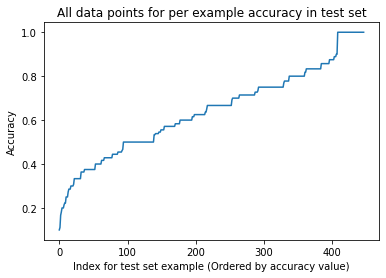

In [67]:
plt.plot(sorted(correctPerExample, reverse=False))
plt.xlabel('Index for test set example (Ordered by accuracy value)')
plt.ylabel('Accuracy')
plt.title('All data points for per example accuracy in test set')

Text(0.5, 1.0, 'Histogram to show per example accuracy')

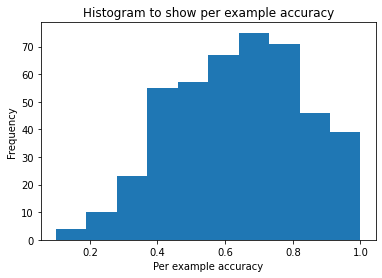

In [62]:
plt.hist(correctPerExample)
plt.xlabel('Per example accuracy')
plt.ylabel('Frequency')
plt.title('Histogram to show per example accuracy')

# Bonus 1 point: Compute the accuracy for the entire test set.  

In [25]:
def get_evaluation_metrics_scores(yTrue, yPred):
    model_accuracy = accuracy_score(yTrue, yPred)
    print(f'The accuracy of the model = {model_accuracy:.4f}')

    model_precision = precision_score(yTrue, yPred, average='macro')
    print(f'The precision of the model with macro average = {model_precision:.4f}')

    model_recall = recall_score(yTrue, yPred, average='macro')
    print(f'The recall of the model with macro average = {model_recall:.4f}')

    model_f1score = f1_score(yTrue, yPred, average='macro')
    print(f'The f1 score of the model with macro average = {model_f1score:.4f}')

In [26]:
get_evaluation_metrics_scores(y_valid_true, y_valid_pred)

The accuracy of the model = 0.7645
The precision of the model with macro average = 0.6821
The recall of the model with macro average = 0.4530
The f1 score of the model with macro average = 0.5104


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
get_evaluation_metrics_scores(y_test_true, y_test_pred)

The accuracy of the model = 0.6145
The precision of the model with macro average = 0.2779
The recall of the model with macro average = 0.1762
The f1 score of the model with macro average = 0.1911


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Histogram to show class imbalance')

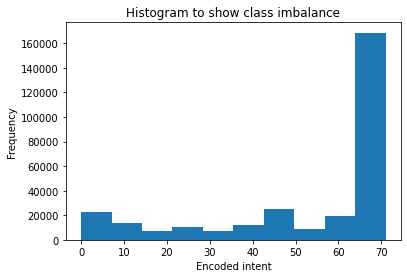

In [28]:
plt.hist(y_train_true)
plt.xlabel('Encoded intent')
plt.ylabel('Frequency')
plt.title('Histogram to show class imbalance')

# Bonus 4 points: Find out what are the best features per class.

In [49]:
bfpc = {'Class': labelEncoder.classes_, 'Feature with highest coefficient': [None] * len(labelEncoder.classes_)}
for index, label in enumerate(labelEncoder.classes_):
    if index in classifier.classes_:
        coeffIndex = list(classifier.classes_).index(index)
        highestCoeff = np.argsort(classifier.coef_[coeffIndex])[-1:][0]
        bfpc['Feature with highest coefficient'][index] = vectorizer.get_feature_names_out()[highestCoeff]

bfpc = pd.DataFrame(data=bfpc, columns=['Class', 'Feature with highest coefficient'])
print(bfpc)

                      Class Feature with highest coefficient
0    b-alarm/alarm_modifier                             None
1                   b-album                            album
2                  b-artist                           ashley
3             b-best_rating                               of
4   b-condition_description                           nearby
..                      ...                              ...
67                   i-sort                         twenties
68                  i-track                             None
69      i-weather/attribute                               of
70                        o                             need
71      orecurring_datetime                             None

[72 rows x 2 columns]
